In [5]:
#Instalar el algoritmo ML xgboost
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---- ----------------------------------- 16.0/150.0 MB 92.0 MB/s eta 0:00:02
   ---------- ---------------------------- 39.1/150.0 MB 103.5 MB/s eta 0:00:02
   --------------- ----------------------- 60.8/150.0 MB 104.8 MB/s eta 0:00:01
   --------------------- ----------------- 84.1/150.0 MB 105.4 MB/s eta 0:00:01
   --------------------------- ---------- 109.6/150.0 MB 107.7 MB/s eta 0:00:01
   --------------------------------- ---- 133.4/150.0 MB 109.3 MB/s eta 0:00:01
   -------------------------------------  149.9/150.0 MB 110.1 MB/s eta 0:00:01
   -------------------------------------  149.9/150.0 MB 110.1 MB/s eta 0:00:01
   --------------------------------------- 150.0/150.0 MB 91.3 MB/s eta 0:00:00


Paso 1: Librerías cargadas.
Archivo 'train (1).csv' cargado exitosamente.
Primeras 5 filas del DataFrame:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN

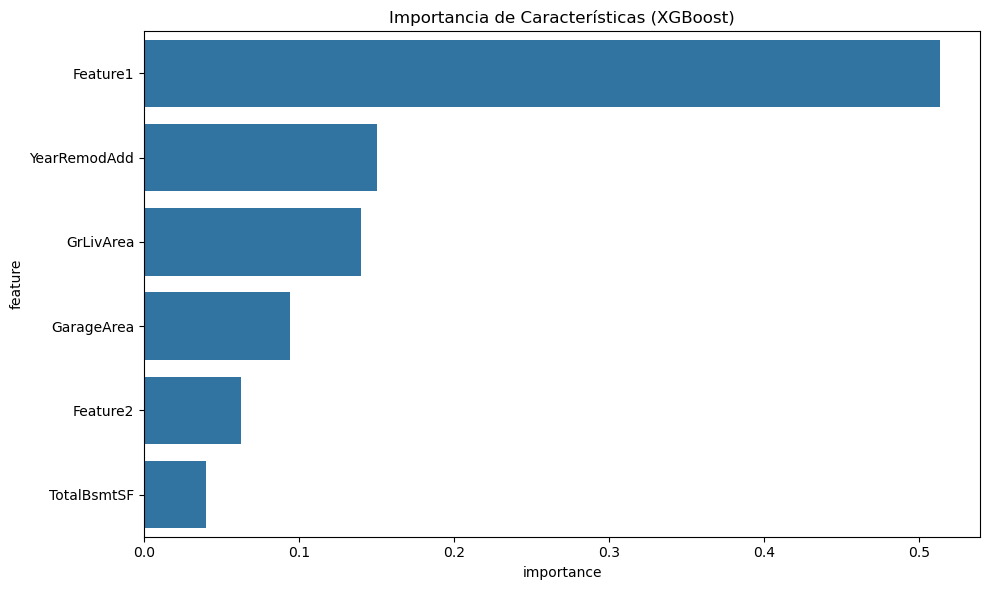

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import warnings

# Ignorar advertencias futuras para mantener la salida limpia
warnings.simplefilter(action='ignore', category=FutureWarning)

#Paso 1: Cargar Librerías Esenciales
# (Hecho arriba con las importaciones)
print("Paso 1: Librerías cargadas.")

# --- Cargar el Dataset ---
# Carga el archivo CSV especificado en un DataFrame de pandas
# Asegúrate de que la ruta al archivo sea correcta para tu entorno.
file_path = 'train (1).csv'
df = pd.read_csv(file_path)

print(f"Archivo '{file_path}' cargado exitosamente.")
print("Primeras 5 filas del DataFrame:")
print(df.head())
print("\nInformación del DataFrame:")
df.info()

#Paso 2: Seleccionar Características
features = ['GarageArea', 'YearRemodAdd', 'TotalBsmtSF', 'GrLivArea']
target = 'SalePrice'

# Asegurarse de que las columnas existen
missing_cols = [col for col in features + [target] if col not in df.columns]
if missing_cols:
    print(f"\nError: Las siguientes columnas no se encontraron en el CSV: {missing_cols}")
    # Considera agregar exit() si quieres que el script se detenga aquí en caso de error
    # exit()
else:
    # Seleccionar solo las columnas necesarias y manejar valores faltantes
    df_selected = df[features + [target]].copy()
    initial_rows = len(df_selected)
    df_selected.dropna(subset=features + [target], inplace=True)
    removed_rows = initial_rows - len(df_selected)
    if removed_rows > 0:
        print(f"\nSe eliminaron {removed_rows} filas con valores faltantes en las columnas seleccionadas.")

    X = df_selected[features]
    y = df_selected[target]

    print(f"\nPaso 2: Características seleccionadas: {features}")
    print("Dimensiones de X:", X.shape)
    print("Dimensiones de y:", y.shape)

    # Paso 3: Aplicar PCA
    # Instanciar y ajustar PCA
    pca = PCA(n_components=len(features))
    pca.fit(X)

    print("\nPaso 3: PCA aplicado.")

    #Paso 4: Creación de Nuevas Características
    df_selected['Feature1'] = df_selected['GrLivArea'] + df_selected['TotalBsmtSF']
    df_selected['Feature2'] = df_selected['TotalBsmtSF'] * df_selected['YearRemodAdd']

    print("\nPaso 4: Nuevas características creadas: Feature1, Feature2.")
    print("Primeras 5 filas con nuevas características:")
    print(df_selected[['GrLivArea', 'TotalBsmtSF', 'YearRemodAdd', 'Feature1', 'Feature2']].head())

    #Paso 5 y 6: Modelización con XGBoost y Evaluación
    # Preparar datos para el modelo
    features_final = features + ['Feature1', 'Feature2']
    X_final = df_selected[features_final]
    y_log = np.log1p(y) # Transformación logarítmica

    # Dividir datos en entrenamiento y prueba
    X_train, X_test, y_train_log, y_test_log = train_test_split(X_final, y_log, test_size=0.2, random_state=42)

    print("\nPaso 5: Preparando modelo XGBoost...")
    print(f"Usando características: {features_final}")
    print(f"Tamaño set entrenamiento: {X_train.shape[0]} filas")
    print(f"Tamaño set prueba: {X_test.shape[0]} filas")

    # Instanciar y entrenar el modelo XGBoost
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                               n_estimators=1000,
                               learning_rate=0.05,
                               max_depth=5,
                               subsample=0.8,
                               colsample_bytree=0.8,
                               random_state=42,
                               early_stopping_rounds=10)

    print("Entrenando el modelo XGBoost...")
    xgb_model.fit(X_train, y_train_log,
                eval_set=[(X_test, y_test_log)],
                verbose=False)

    # Hacer predicciones
    y_pred_log = xgb_model.predict(X_test)

    # Calcular RMSLE (RMSE sobre valores logarítmicos)
    rmsle = np.sqrt(mean_squared_error(y_test_log, y_pred_log))

    print("\nPaso 6: Evaluación del modelo completada.")
    print(f"El RMSLE (Root Mean Squared Log Error) en el conjunto de prueba es: {rmsle:.5f}")

    # Opcional: Visualizar importancia de características
    print("\nImportancia de las características según XGBoost:")
    try:
        feature_importances = pd.DataFrame({'feature': features_final, 'importance': xgb_model.feature_importances_})
        feature_importances = feature_importances.sort_values('importance', ascending=False)
        print(feature_importances)

        # Graficar importancia (opcional)
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=feature_importances)
        plt.title('Importancia de Características (XGBoost)')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"No se pudo mostrar la importancia de características: {e}")